In [28]:
#dependencies
import pandas as pd
import seaborn as sns
import sqlite3
from sqlite3 import Error
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
#nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
#nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
#force output to display the full description
# pd.set_option('display.max_colwidth', -1)
#create connection to database
# conn = sqlite3.connect('db\wine_data.sqlite')
# c = conn.cursor()

In [7]:
#create the pandas data frame
wine_df = pd.read_csv('/Users/nico_marais/code/Liedjieboer/forward_farming/NLP/Text_data/winemag-data-130k-v2.csv')
#display the top 3 records from the data frame
wine_df.head(3)

,id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's already drinkable, although it will certainly be better from 2016.",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


In [8]:
#inline function to produce word count, splitting on spaces
wine_df['word_count'] = wine_df['description'].apply(lambda x: len(str(x).split(" ")))
wine_df.word_count.describe()

count    129971.000000
mean     40.384440    
std      11.113601    
min      3.000000     
25%      33.000000    
50%      39.000000    
75%      47.000000    
max      135.000000   
Name: word_count, dtype: float64

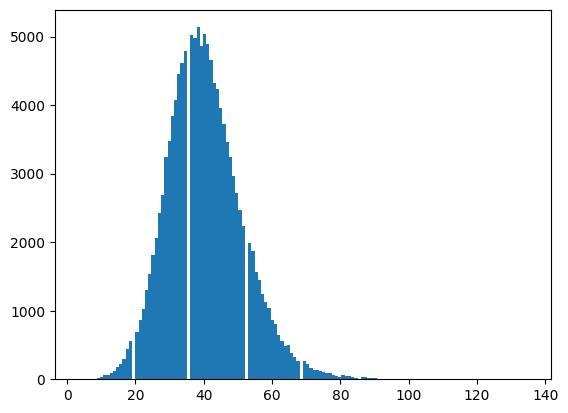

In [9]:
#set x for the histogram and set bins based on max
x = wine_df['word_count']
n_bins = 140
#plot histogram
plt.hist(x, bins=n_bins)
plt.show()

In [10]:
stop_words = set(stopwords.words("english"))
#show how many words are in the list of stop words
print(len(stop_words))
#179

179


In [11]:
#loops through descriptions and cleans them
clean_desc = []
for w in range(len(wine_df.description)):
    desc = wine_df['description'][w].lower()
    
    #remove punctuation
    desc = re.sub('[^a-zA-Z]', ' ', desc)
    
    #remove tags
    desc=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",desc)
    
    #remove digits and special chars
    desc=re.sub("(\\d|\\W)+"," ",desc)
    
    clean_desc.append(desc)
#assign the cleaned descriptions to the data frame
wine_df['clean_desc'] = clean_desc

In [12]:
#calculate the frequency
word_frequency = pd.Series(' '.join(wine_df['clean_desc']).split()).value_counts()[:30]
word_frequency

and        347897
the        221367
a          180076
of         173050
with       120515
this       114193
is         96816 
it         86101 
wine       80360 
flavors    62796 
in         62522 
to         56076 
s          52995 
fruit      49939 
on         45664 
that       40545 
aromas     39639 
palate     38523 
acidity    35003 
finish     34974 
from       32609 
but        31189 
tannins    30878 
drink      30323 
cherry     29322 
black      29024 
ripe       27377 
are        25876 
has        24721 
red        21784 
dtype: int64

In [13]:
#add list of words to stoplist
add_stopwords = ["wine", "drink"]
stop_words = stop_words.union(add_stopwords)
print(len(stop_words))

181


In [19]:
stem_desc = []
for w in range(len(wine_df['clean_desc'])):
    split_text = wine_df['clean_desc'][w].split()

In [17]:
#Stemming
# stm = SnowballStemmer("english")
# split_text = [stm.stem(word) for word in split_text if not word in stop_words] 
# split_text = " ".join(split_text)
# stem_desc.append(split_text)

In [20]:
#Lemmatisation
lem = WordNetLemmatizer()
split_text = [lem.lemmatize(word) for word in split_text if not word in stop_words] 
split_text = " ".join(split_text)
stem_desc.append(split_text)
stem_desc

['big rich dry powered intense spiciness rounded texture lychee dominate fruit profile giving opulent feel aftertaste']

In [21]:
#set the word cloud parameters
wordcloud = WordCloud(width = 800, height = 800, 
                      background_color = 'black', 
                      stopwords = stop_words, 
                      max_words = 1000, 
                      min_font_size = 20).generate(str(stem_desc))

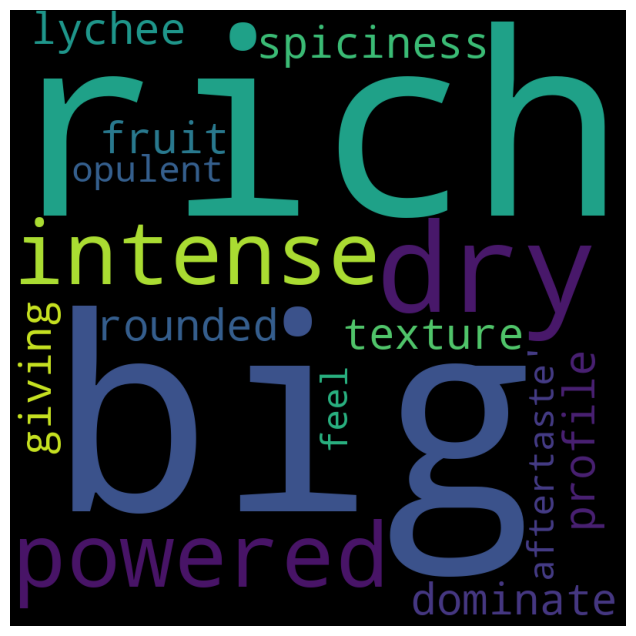

In [22]:
#plot the word cloud
fig = plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
#fig.savefig("wordcloud.png")

In [23]:
def get_trigrams(descriptions, n=None):
    
    vec = CountVectorizer(ngram_range = (3,3), max_features = 20000).fit(descriptions)
    bag_of_words = vec.transform(descriptions)
    sum_words = bag_of_words.sum(axis = 0) 
    words_freq = [(word, sum_words[0, i]) for word, i in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse = True)
   
    return words_freq[:n]

In [26]:
stops = ['wine','the', 'drink', 'an', 'cabernet', 'sauvignon', 'black', 'cherry']
stem_desc = []
for w in range(len(wine_df['clean_desc'])):
    split_text = wine_df['clean_desc'][w].split()
       
    #Lemmatisation
lem = WordNetLemmatizer()
split_text = [lem.lemmatize(word) for word in split_text if not word in stops] 
split_text = " ".join(split_text)
stem_desc.append(split_text)
trigrams = get_trigrams(clean_desc, n=15)


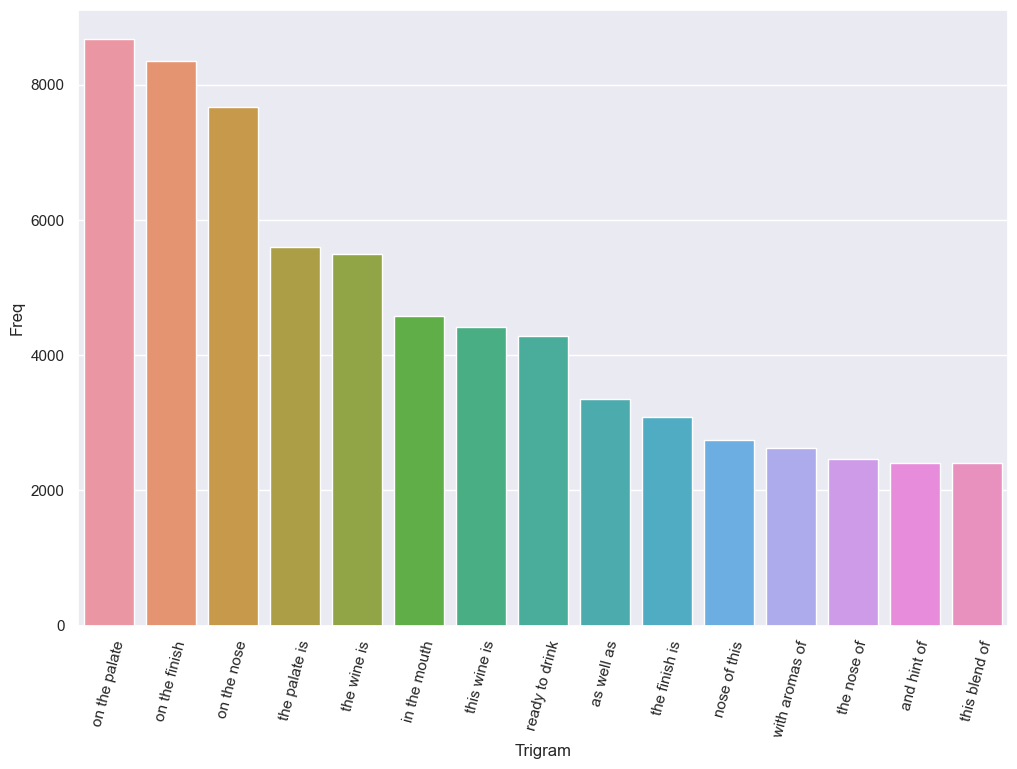

In [29]:
#create a trigram data frame
trigram_df = pd.DataFrame(trigrams)
trigram_df.columns=["Trigram", "Freq"]
#output top 15 rows
trigram_df.head(15)
fig = sns.set(rc = {'figure.figsize':(12,8)})
bp = sns.barplot(x = "Trigram", y = "Freq", data = trigram_df)
bp.set_xticklabels(bp.get_xticklabels(), rotation = 75)
plt.show()